## Import Libraries dan Cek Apakah ada Cuda ?

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## Datasets and Data Loader

In [ ]:
!unzip data.zip -d .

In [2]:
from torchvision import datasets, transforms

# Batch size untuk DataLoader
bs = 128
# Ukuran pemotongan gambar setelah transformasi
crop_size = 64

# Transformasi data untuk dataset pelatihan
train_transform = transforms.Compose([
    # Rotasi gambar secara acak dalam rentang -15 hingga 15 derajat
    transforms.RandomRotation(15),
    # Memotong gambar ke ukuran acak dengan skala antara 80% hingga 100% dari ukuran asli
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    # Membalik gambar secara horizontal secara acak
    transforms.RandomHorizontalFlip(),
    # Mengonversi gambar ke tensor dengan nilai piksel dalam rentang [0, 1]
    transforms.ToTensor()
])

# Transformasi data untuk dataset pengujian
test_transform = transforms.Compose([
    # Ubah ukuran gambar menjadi 70 piksel di sisi terpendek
    transforms.Resize(70),
    # Potong bagian tengah gambar menjadi ukuran tetap (crop_size)
    transforms.CenterCrop(crop_size),
    # Konversi gambar ke tensor dengan nilai piksel dalam rentang [0, 1]
    transforms.ToTensor()
])

# Load dataset pelatihan dari direktori "data/train" dengan transformasi yang telah ditentukan
train_set = datasets.ImageFolder("data/train", transform=train_transform)
# Loader untuk dataset pelatihan dengan batching dan shuffle data
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=0)

# Load dataset pengujian dari direktori "data/test" dengan transformasi yang telah ditentukan
test_set = datasets.ImageFolder("data/test", transform=test_transform)
# Loader untuk dataset pengujian tanpa shuffle
testloader = DataLoader(test_set, batch_size=bs, shuffle=False)

In [3]:
feature, target = next(iter(trainloader))
feature.shape, target.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

In [4]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

## Arsitektur dan Config

In [5]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    """
    Convolutional Neural Network (CNN) untuk klasifikasi hama tanaman hydrangea
    menjadi invasif atau non-invasif. Arsitektur terdiri dari beberapa lapisan
    konvolusi untuk ekstraksi fitur dan lapisan fully connected untuk klasifikasi.

    Atribut:
    - conv: Model sequential yang berisi empat blok konvolusi dan lapisan flatten.
    - fc: Model sequential yang berisi lapisan fully connected untuk klasifikasi.

    Metode:
    - forward(x): Mendefinisikan proses forward pada jaringan.
    - _conv_block(in_channels, out_channels): Membuat blok konvolusi yang dapat digunakan kembali.
    """
    def __init__(self):
        """
        Menginisialisasi model CNN dengan menyiapkan blok-blok konvolusi
        dan lapisan fully connected.
        """
        super().__init__()

        # Blok Konvolusi
        self.conv = nn.Sequential(
            self._conv_block(3, 8),   # Blok 1 dengan 3 saluran input (RGB) dan 8 saluran output
            self._conv_block(8, 16),  # Blok 2 dengan 16 saluran output
            self._conv_block(16, 32), # Blok 3 dengan 32 saluran output
            self._conv_block(32, 64), # Blok 4 dengan 64 saluran output
            nn.Flatten()  # Meratakan hasil sebelum masuk ke fully connected layer
        )

        # Lapisan Fully Connected
        self.fc = nn.Sequential(
            nn.Linear(1024, 256),   # Lapisan fully connected dengan 256 unit
            nn.Dropout(0.1),       # Dropout untuk mencegah overfitting
            nn.ReLU(),             # Fungsi aktivasi ReLU
            nn.Linear(256, 2),     # Lapisan output dengan 2 kelas (invasif atau non-invasif)
            nn.LogSoftmax(dim=1)   # Log-Softmax untuk stabilitas perhitungan probabilitas
        )

    def _conv_block(self, in_channels, out_channels):
        """
        Membuat blok konvolusi yang terdiri dari Conv2d, aktivasi ReLU,
        dan MaxPooling.

        Args:
        - in_channels (int): Jumlah saluran input.
        - out_channels (int): Jumlah saluran output.

        Returns:
        - nn.Sequential: Blok konvolusi yang telah didefinisikan.
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),  # Fungsi aktivasi
            nn.MaxPool2d(kernel_size=2, stride=2)  # Mengurangi dimensi spasial menjadi setengahnya
        )

    def forward(self, x):
        """
        Mendefinisikan proses forward pada CNN.

        Args:
        - x (Tensor): Tensor input dengan bentuk [batch_size, channels, tinggi, lebar].

        Returns:
        - Tensor: Log probabilitas untuk setiap kelas.
        """
        x = self.conv(x)  # Memproses input melalui lapisan konvolusi
        x = self.fc(x)    # Memproses melalui lapisan fully connected
        return x

In [6]:
import json

class Config:
    """
    Kelas Config digunakan untuk menyimpan, memuat, dan mengelola parameter konfigurasi
    model atau eksperimen deep learning.

    Atribut:
    - params (dict): Menyimpan parameter konfigurasi dalam bentuk dictionary.

    Metode:
    - save(filepath): Menyimpan konfigurasi ke file JSON.
    - load(filepath): Memuat konfigurasi dari file JSON.
    - get(key, default): Mengambil nilai parameter berdasarkan kunci dengan nilai default opsional.
    """

    def __init__(self, **kwargs):
        """
        Menginisialisasi kelas Config dengan parameter yang diberikan.

        Args:
        - **kwargs: Parameter konfigurasi yang diteruskan sebagai pasangan kunci-nilai.
        """
        self.params = kwargs

    def save(self, filepath="config.json"):
        """
        Menyimpan parameter konfigurasi ke file JSON.

        Args:
        - filepath (str): Nama file tempat konfigurasi akan disimpan.
                          Default adalah 'config.json'.
        """
        with open(filepath, 'w') as file:
            json.dump(self.params, file)

    def load(self, filepath="config.json"):
        """
        Memuat parameter konfigurasi dari file JSON.

        Args:
        - filepath (str): Nama file tempat konfigurasi akan dimuat.
                          Default adalah 'config.json'.
        """
        with open(filepath, 'r') as file:
            self.params = json.load(file)

    def get(self, key, default=None):
        """
        Mengambil nilai parameter berdasarkan kunci.

        Args:
        - key (str): Kunci parameter yang ingin diambil.
        - default: Nilai default jika kunci tidak ditemukan. Default adalah None.

        Returns:
        - Nilai parameter yang sesuai dengan kunci, atau nilai default jika tidak ditemukan.
        """
        return self.params.get(key, default)

In [7]:
config = Config(batch_size=32, crop_size=224, lr=0.001)
config.save()

## Build Class Callback

In [8]:
import matplotlib.pyplot as plt
from termcolor import colored
import torch
import os

class Callback:
    """
    Kelas Callback digunakan untuk memantau proses pelatihan model, menyimpan checkpoint
    model terbaik, dan menghentikan pelatihan lebih awal (early stopping) jika diperlukan.

    Atribut:
    - model: Model yang sedang dilatih.
    - config: Konfigurasi pelatihan.
    - outdir (str): Direktori tempat menyimpan checkpoint model. Default: 'model'.
    - patience (int): Jumlah epoch sebelum menghentikan pelatihan jika tidak ada peningkatan skor. Default: 5.
    - best_score (float): Skor terbaik yang diperoleh selama pelatihan.
    - counter (int): Hitungan epoch tanpa peningkatan skor.
    - early_stop (bool): Menandakan apakah pelatihan harus dihentikan lebih awal.
    - history (dict): Riwayat metrik pelatihan dan pengujian.

    Metode:
    - log(train_cost, test_cost, train_score, test_score): Mencatat metrik pelatihan dan pengujian.
    - save_checkpoint(): Menyimpan state model terbaik.
    - early_stopping(model, monitor): Mengecek kondisi untuk early stopping berdasarkan metrik tertentu.
    - plot_metrics(): Menampilkan kurva metrik cost dan akurasi.
    """

    def __init__(self, model, config, outdir="model", patience=5):
        self.model = model
        self.config = config
        self.outdir = outdir
        self.patience = patience
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.history = {
            "train_cost": [],
            "test_cost": [],
            "train_score": [],
            "test_score": []
        }

    def log(self, train_cost, test_cost, train_score, test_score):
        """
        Mencatat metrik pelatihan dan pengujian pada setiap epoch.

        Args:
        - train_cost (float): Biaya (loss) pada data pelatihan.
        - test_cost (float): Biaya (loss) pada data pengujian.
        - train_score (float): Skor akurasi pada data pelatihan.
        - test_score (float): Skor akurasi pada data pengujian.
        """
        self.history["train_cost"].append(train_cost)
        self.history["test_cost"].append(test_cost)
        self.history["train_score"].append(train_score)
        self.history["test_score"].append(test_score)
        print(f"Train_cost  = {train_cost:.4f} | Test_cost  = {test_cost:.4f} | "
              f"Train_score = {train_score:.4f} | Test_score = {test_score:.4f}")

    def save_checkpoint(self):
        """
        Menyimpan state model terbaik ke dalam file.

        File akan disimpan dalam direktori yang ditentukan oleh `outdir`.
        """
        if not os.path.exists(self.outdir):
            os.makedirs(self.outdir)
        torch.save(self.model.state_dict(), f"{self.outdir}/best_model.pth")
        print(f"Model checkpoint saved at {self.outdir}/best_model.pth")

    def early_stopping(self, model, monitor="test_score"):
        """
        Mengecek kondisi untuk menghentikan pelatihan lebih awal.

        Args:
        - model: Model yang sedang dilatih.
        - monitor (str): Metrik yang dipantau, default adalah 'test_score'.

        Returns:
        - bool: True jika pelatihan harus dihentikan, False jika tidak.
        """
        score = self.history[monitor][-1]
        if self.best_score is None or score > self.best_score:
            self.best_score = score
            self.counter = 0
            self.save_checkpoint()
        else:
            self.counter += 1
            print(f"\033[91mEarlyStopping counter: {self.counter} out of {self.patience}\033[0m")
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

    def plot_metrics(self):
        """
        Menampilkan kurva cost dan akurasi untuk data pelatihan dan pengujian.
        """
        plt.figure(figsize=(12, 5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(self.history["train_cost"], label="Train Cost", marker='o')
        plt.plot(self.history["test_cost"], label="Test Cost", marker='x')
        plt.title("Cost Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Cost")
        plt.legend()

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.history["train_score"], label="Train Accuracy", marker='o')
        plt.plot(self.history["test_score"], label="Test Accuracy", marker='x')
        plt.title("Accuracy Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.show()

## Training Preparation

In [9]:
# Membuat instance model CNN dan memindahkannya ke GPU/CPU
model = CNN().to(device)

# Fungsi loss menggunakan Negative Log Likelihood (cocok dengan log_softmax)
criterion = nn.NLLLoss()

# Optimizer menggunakan AdamW dengan learning rate dari konfigurasi
optimizer = torch.optim.AdamW(model.parameters(), lr=config.get("lr", 0.001))

# Callback untuk memonitor pelatihan dan menyimpan model terbaik
callback = Callback(model, config)

## Training

In [10]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    """
    Fungsi untuk menjalankan loop pelatihan atau pengujian CNN.

    Args:
        mode (str): Mode operasi, "train" untuk pelatihan, "test" untuk pengujian.
        dataset (torch.utils.data.Dataset): Dataset yang digunakan.
        dataloader (torch.utils.data.DataLoader): DataLoader untuk iterasi batch.
        model (torch.nn.Module): Model CNN yang dilatih atau diuji.
        criterion (torch.nn.Module): Fungsi loss untuk menghitung kerugian.
        optimizer (torch.optim.Optimizer): Optimizer untuk memperbarui bobot (hanya saat mode train).
        device (str): Perangkat yang digunakan, GPU atau CPU.

    Returns:
        tuple: (cost, acc) berupa rata-rata loss dan akurasi model.
    """
    # Mengatur mode model: train (pelatihan) atau eval (pengujian)
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()

    cost = 0  # Total kerugian
    correct = 0  # Total prediksi yang benar

    # Loop untuk setiap batch dalam dataloader
    for feature, target in tqdm(dataloader, desc=mode.title()):
        # Memindahkan fitur dan target ke perangkat (GPU/CPU)
        feature, target = feature.to(device), target.to(device)

        # Forward pass: mendapatkan output prediksi
        output = model(feature)

        # Menghitung loss
        loss = criterion(output, target)

        # Jika mode adalah train, lakukan backward pass dan update bobot
        if mode == "train":
            loss.backward()  # Backpropagation
            optimizer.step()  # Update bobot
            optimizer.zero_grad()  # Reset gradien

        # Akumulasi loss dan jumlah prediksi yang benar
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()

    # Rata-rata cost dan akurasi
    cost = cost / len(dataset)
    acc = correct / len(dataset)

    return cost, acc


Epoch 1


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.6891 | Test_cost  = 0.6814 | Train_score = 0.5220 | Test_score = 0.5150
Model checkpoint saved at model/best_model.pth

Epoch 2


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.6610 | Test_cost  = 0.6201 | Train_score = 0.6300 | Test_score = 0.6950
Model checkpoint saved at model/best_model.pth

Epoch 3


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.5842 | Test_cost  = 0.5687 | Train_score = 0.7220 | Test_score = 0.7150
Model checkpoint saved at model/best_model.pth

Epoch 4


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.5203 | Test_cost  = 0.4774 | Train_score = 0.7590 | Test_score = 0.7700
Model checkpoint saved at model/best_model.pth

Epoch 5


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.4700 | Test_cost  = 0.4277 | Train_score = 0.7720 | Test_score = 0.8125
Model checkpoint saved at model/best_model.pth

Epoch 6


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.4488 | Test_cost  = 0.4365 | Train_score = 0.7890 | Test_score = 0.7925
EarlyStopping counter: 1 out of 5

Epoch 7


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.4387 | Test_cost  = 0.3974 | Train_score = 0.7880 | Test_score = 0.8325
Model checkpoint saved at model/best_model.pth

Epoch 8


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.4259 | Test_cost  = 0.4106 | Train_score = 0.8090 | Test_score = 0.8225
EarlyStopping counter: 1 out of 5

Epoch 9


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.4093 | Test_cost  = 0.4011 | Train_score = 0.8130 | Test_score = 0.8300
EarlyStopping counter: 2 out of 5

Epoch 10


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.4115 | Test_cost  = 0.3997 | Train_score = 0.8110 | Test_score = 0.8375
Model checkpoint saved at model/best_model.pth

Epoch 11


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.4257 | Test_cost  = 0.3906 | Train_score = 0.8120 | Test_score = 0.8400
Model checkpoint saved at model/best_model.pth

Epoch 12


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.4071 | Test_cost  = 0.4549 | Train_score = 0.8180 | Test_score = 0.7850
EarlyStopping counter: 1 out of 5

Epoch 13


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.3881 | Test_cost  = 0.3793 | Train_score = 0.8240 | Test_score = 0.8375
EarlyStopping counter: 2 out of 5

Epoch 14


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.3706 | Test_cost  = 0.3621 | Train_score = 0.8330 | Test_score = 0.8450
Model checkpoint saved at model/best_model.pth

Epoch 15


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.3583 | Test_cost  = 0.3497 | Train_score = 0.8440 | Test_score = 0.8450
EarlyStopping counter: 1 out of 5

Epoch 16


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.3545 | Test_cost  = 0.3515 | Train_score = 0.8500 | Test_score = 0.8500
Model checkpoint saved at model/best_model.pth

Epoch 17


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.3384 | Test_cost  = 0.3378 | Train_score = 0.8540 | Test_score = 0.8550
Model checkpoint saved at model/best_model.pth

Epoch 18


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.3458 | Test_cost  = 0.3909 | Train_score = 0.8560 | Test_score = 0.8500
EarlyStopping counter: 1 out of 5

Epoch 19


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.3509 | Test_cost  = 0.3237 | Train_score = 0.8500 | Test_score = 0.8550
EarlyStopping counter: 2 out of 5

Epoch 20


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.3473 | Test_cost  = 0.3384 | Train_score = 0.8550 | Test_score = 0.8550
EarlyStopping counter: 3 out of 5

Epoch 21


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.3375 | Test_cost  = 0.3271 | Train_score = 0.8480 | Test_score = 0.8500
EarlyStopping counter: 4 out of 5

Epoch 22


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train_cost  = 0.3223 | Test_cost  = 0.3134 | Train_score = 0.8600 | Test_score = 0.8500
EarlyStopping counter: 5 out of 5
Early stopping triggered!


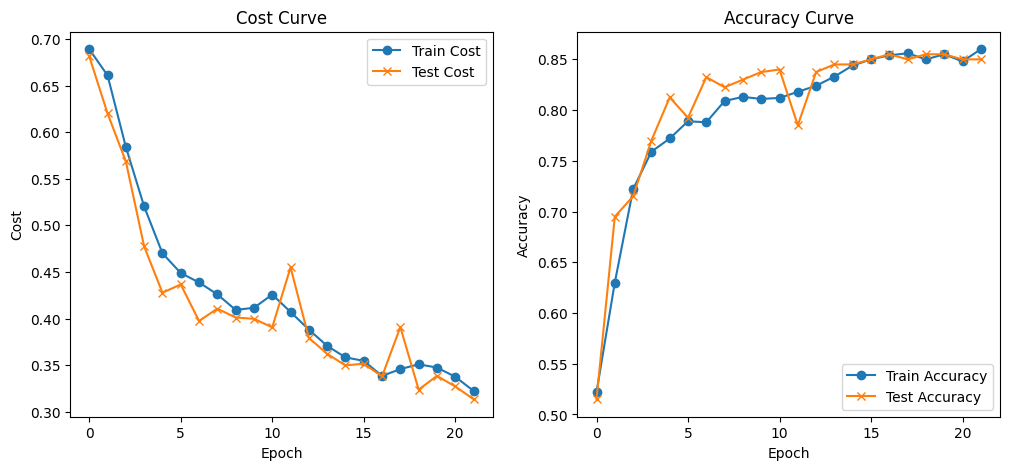

In [11]:
epoch = 1  # Inisialisasi epoch

# Loop utama untuk pelatihan
while True:
    print(f"\nEpoch {epoch}")

    # Proses pelatihan
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)

    # Proses pengujian (tanpa gradien)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Log hasil cost dan akurasi dari proses train dan test
    callback.log(train_cost, test_cost, train_score, test_score)

    # Cek kondisi untuk early stopping
    if callback.early_stopping(model, monitor="test_score"):
        print("\033[91mEarly stopping triggered!\033[0m")  # Berhenti jika kondisi terpenuhi
        break

    # Tambahkan epoch jika tidak berhenti
    epoch += 1

# Plot kurva metrik pelatihan
callback.plot_metrics()

## Evaluasi

In [12]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrices(model, trainloader, testloader, label2cat, device):
    """
    Menampilkan confusion matrix untuk dataset pelatihan dan pengujian.

    Parameter:
    - model: Model PyTorch yang telah dilatih
    - trainloader: DataLoader untuk dataset pelatihan
    - testloader: DataLoader untuk dataset pengujian
    - label2cat: Daftar label kelas untuk ditampilkan
    - device: Perangkat ('cpu' atau 'cuda') tempat model dan data berada
    """

    def get_predictions(dataloader):
        """Mengambil prediksi dan label asli dari DataLoader."""
        preds, labels = [], []
        model.eval()  # Mengatur model ke mode evaluasi
        with torch.no_grad():  # Tidak perlu menghitung gradien
            for inputs, targets in dataloader:
                # Pindahkan data ke perangkat yang sesuai
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                # Ambil label prediksi dan label asli
                preds.extend(outputs.argmax(dim=1).cpu().numpy())
                labels.extend(targets.cpu().numpy())
        return labels, preds

    # Mengambil prediksi untuk dataset pelatihan dan pengujian
    train_labels, train_preds = get_predictions(trainloader)
    test_labels, test_preds = get_predictions(testloader)

    # Membuat plot confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Fungsi pembantu untuk plot matrix
    def plot_cm(cm, title, ax):
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                     xticklabels=label2cat, yticklabels=label2cat, ax=ax)
        ax.set_title(title)
        ax.set_xlabel('Label Prediksi')
        ax.set_ylabel('Label Asli')

    # Plot confusion matrix untuk pelatihan dan pengujian
    plot_cm(confusion_matrix(train_labels, train_preds), "Confusion Matrix - Pelatihan", axes[0])
    plot_cm(confusion_matrix(test_labels, test_preds), "Confusion Matrix - Pengujian", axes[1])

    plt.tight_layout()
    plt.show()

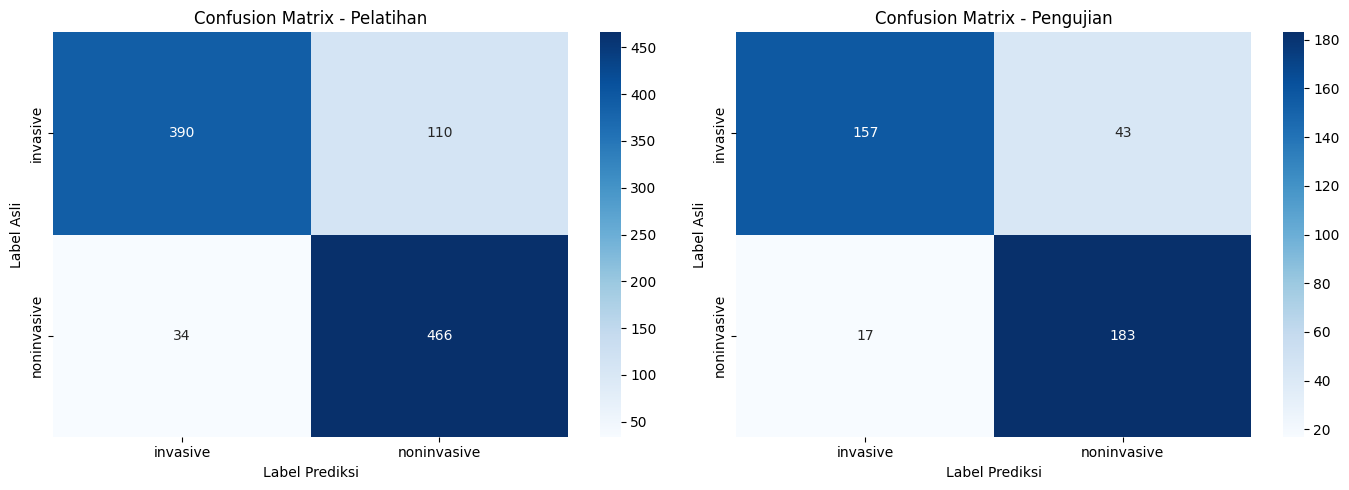

In [13]:
label2cat = train_set.classes
plot_confusion_matrices(model, trainloader, testloader, label2cat, device)

In [14]:
from sklearn.metrics import classification_report
import torch

def plot_classification_reports(model, trainloader, testloader, label2cat, device):
    """
    Menampilkan laporan klasifikasi (classification report) untuk dataset pelatihan dan pengujian.

    Parameter:
    - model: Model PyTorch yang telah dilatih
    - trainloader: DataLoader untuk dataset pelatihan
    - testloader: DataLoader untuk dataset pengujian
    - label2cat: Daftar label kelas untuk ditampilkan
    - device: Perangkat ('cpu' atau 'cuda') tempat model dan data berada
    """

    def get_predictions(dataloader):
        """Mengambil prediksi dan label asli dari DataLoader."""
        preds, labels = [], []
        model.eval()  # Mengatur model ke mode evaluasi
        with torch.no_grad():  # Tidak perlu menghitung gradien
            for inputs, targets in dataloader:
                # Pindahkan data ke perangkat yang sesuai
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                # Ambil prediksi dengan argmax
                preds.extend(outputs.argmax(dim=1).cpu().numpy())
                labels.extend(targets.cpu().numpy())
        return labels, preds

    # Mengambil prediksi untuk dataset pelatihan dan pengujian
    train_labels, train_preds = get_predictions(trainloader)
    test_labels, test_preds = get_predictions(testloader)

    # Menampilkan laporan klasifikasi
    print("\nLaporan Klasifikasi untuk Dataset Pelatihan:\n")
    print(classification_report(train_labels, train_preds, target_names=label2cat))

    print("\nLaporan Klasifikasi untuk Dataset Pengujian:\n")
    print(classification_report(test_labels, test_preds, target_names=label2cat))

In [15]:
plot_classification_reports(model, trainloader, testloader, label2cat, device)


Laporan Klasifikasi untuk Dataset Pelatihan:

              precision    recall  f1-score   support

    invasive       0.92      0.80      0.86       500
 noninvasive       0.82      0.93      0.87       500

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Laporan Klasifikasi untuk Dataset Pengujian:

              precision    recall  f1-score   support

    invasive       0.90      0.79      0.84       200
 noninvasive       0.81      0.92      0.86       200

    accuracy                           0.85       400
   macro avg       0.86      0.85      0.85       400
weighted avg       0.86      0.85      0.85       400



In [16]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_random_predictions(model, dataloader, label2cat, device, num_images=20):
    """
    Menampilkan sejumlah gambar acak dari DataLoader dengan label prediksi dan label asli.

    Parameter:
    - model: Model PyTorch yang telah dilatih
    - dataloader: DataLoader untuk dataset yang akan diprediksi
    - label2cat: Daftar label kelas
    - device: Perangkat ('cpu' atau 'cuda') tempat model berada
    - num_images: Jumlah gambar yang ingin ditampilkan (default 20)
    """

    model.eval()  # Mengatur model ke mode evaluasi

    # List untuk menyimpan gambar, label asli, dan prediksi
    images, labels, preds = [], [], []

    # Mengumpulkan prediksi dan data tanpa menghitung gradien
    with torch.no_grad():
        for inputs, targets in dataloader:
            # Pindahkan data ke perangkat yang sesuai
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            # Ambil prediksi dengan argmax
            _, predicted = torch.max(outputs, 1)

            # Simpan data ke dalam list
            images.extend(inputs.cpu())  # Kembalikan ke CPU untuk visualisasi
            labels.extend(targets.cpu())
            preds.extend(predicted.cpu())

    # Pilih secara acak num_images dari data
    random_indices = random.sample(range(len(images)), num_images)

    plt.figure(figsize=(15, 8))

    for i, idx in enumerate(random_indices):
        # Mengatur channel gambar agar sesuai dengan format matplotlib
        img = images[idx].permute(1, 2, 0).numpy()  # Rearrange channel order
        true_label = label2cat[labels[idx].item()]  # Label asli
        pred_label = label2cat[preds[idx].item()]   # Label prediksi

        # Pewarnaan judul: hijau jika benar, merah jika salah
        color = "green" if true_label == pred_label else "red"

        plt.subplot(4, 5, i + 1)  # Plot dalam grid 4x5
        plt.imshow(img)
        plt.axis("off")  # Sembunyikan sumbu
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)

    plt.tight_layout()
    plt.show()

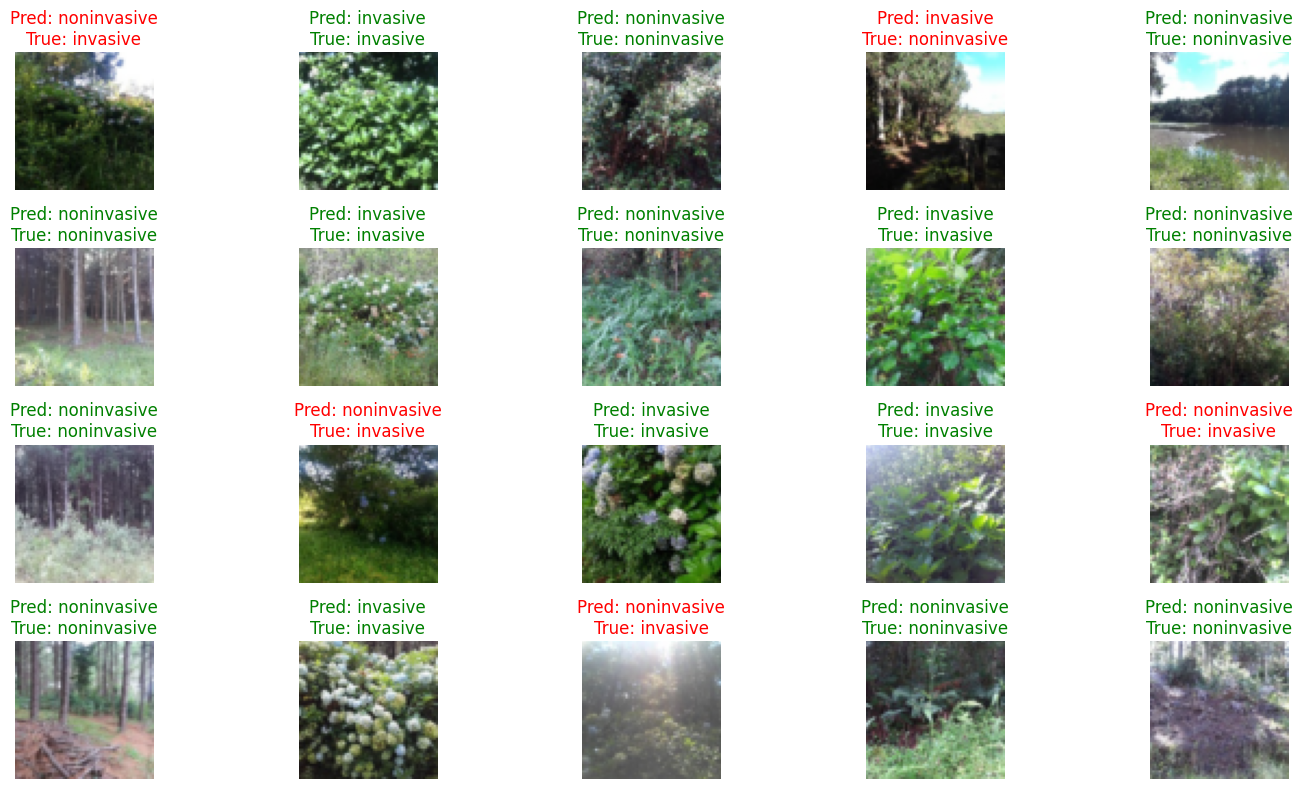

In [17]:
plot_random_predictions(model, testloader, label2cat, device)

## Model Summary

In [18]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
summary(model, input_size=(3, 64, 64), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]             224
              ReLU-2            [-1, 8, 64, 64]               0
         MaxPool2d-3            [-1, 8, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           1,168
              ReLU-5           [-1, 16, 32, 32]               0
         MaxPool2d-6           [-1, 16, 16, 16]               0
            Conv2d-7           [-1, 32, 16, 16]           4,640
              ReLU-8           [-1, 32, 16, 16]               0
         MaxPool2d-9             [-1, 32, 8, 8]               0
           Conv2d-10             [-1, 64, 8, 8]          18,496
             ReLU-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                  [

In [19]:
model

CNN(
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): Dropou